# UFO Modeling Lab

<u>Use Case</u>
<p>Mr. K wants to deploy a network of 10 sensors across the globe. He would like to locate these sensors in the center of the most likely locations for UFO sighting.</p>

<u>Goal</u>
<p>build a model that will output 10 points (point = pair of {long,lat}) to place the sensors</p> 

<u>Table Of Contents</u>
1. [Data Collection](#DC)
1. [Assumptions](#assumptions)
1. [Model Selection](#MS)
1. [Feature Selection](#FS)
1. [Handling Missing Values](#HMV)
1. [EDA](#eda)
1. [Data Preparation](#dp)
1. [Modeling](#model)
1. [Results](#results)
1. [Summary](#summary)

<u>Note</u>
<p>in every code cell that I'm using external libraries I'm importing it every time, although I can import all of them once on the start of the notebook, I wanted to show what libraries I'm using on every step</p>

## Data Collection<a id='DC'></a>
### Downloading a File from an S3 Bucket to Notebook instance<a id='S3To'></a>

In [1]:
import boto3
import botocore

BUCKET_NAME = '<PUT_HERE_THE_BUCKET_NAME>'
KEY = 'ModelingLab - 2019/ufo_fullset.csv'

s3 = boto3.resource('s3')

try:
    s3.Bucket(BUCKET_NAME).download_file(KEY, 'ufo_fullset.csv')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

'\nimport boto3\nimport botocore\n\nBUCKET_NAME = \'allcloud-idan-aws-certified-ml-2019\'\nKEY = \'ModelingLab - 2019/ufo_fullset.csv\'\n\ns3 = boto3.resource(\'s3\')\n\ntry:\n    s3.Bucket(BUCKET_NAME).download_file(KEY, \'ufo_fullset.csv\')\nexcept botocore.exceptions.ClientError as e:\n    if e.response[\'Error\'][\'Code\'] == "404":\n        print("The object does not exist.")\n    else:\n        raise\n'

### Load Data from CSV File to DataFrame using Pandas<a id='LoadData'></a>

In [2]:
import pandas as pd 

data = pd.read_csv("ufo_fullset.csv")
data.head()

,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
0,1977-04-04T04:02:23.340Z,1977-03-31,23:46,circle,4,1,rain,Ila,Bashirian,47.329444,-122.578889,Y,N,N,explained
1,1982-11-22T02:06:32.019Z,1982-11-15,22:04,disk,4,1,partly cloudy,Eriberto,Runolfsson,52.664913,-1.034894,Y,Y,N,explained
2,1992-12-07T19:06:52.482Z,1992-12-07,19:01,circle,49,1,clear,Miller,Watsica,38.951667,-92.333889,Y,N,N,explained
3,2011-02-24T21:06:34.898Z,2011-02-21,20:56,disk,13,1,partly cloudy,Clifton,Bechtelar,41.496944,-71.367778,Y,N,N,explained
4,1991-03-09T16:18:45.501Z,1991-03-09,11:42,circle,17,1,mostly cloudy,Jayda,Ebert,47.606389,-122.330833,Y,N,N,explained


<u>Feature Explanation</u>
<ul>
    <li>reportedTimestamp: The date when the UFO sighting was reported</li>
    <li>eventDate: The date when the UFO sighting happened</li>
    <li>eventTime: The time when the UFO sighting happened (24 hour format)</li>
    <li>latitude: The location where the UFO sighting happened</li>
    <li>longitude: The location where the UFO sighting happened</li>
    <li>shape: The shape of the UFO</li>
    <li>duration: How many seconds the sighting happened</li>
    <li>witnesses: The amount of witnesses that saw the UFO</li>
    <li>weather: The weather when the sighting happened</li>
    <li>firstName: The first name of the person who saw a UFO</li>
    <li>lastName: The last name of the person who saw a UFO</li>
    <li>sighting: If a UFO was sighted (is always Y = Yes)</li>
    <li>physicalEvidence: Whether there was physical evidence left by UFO (Y = Yes, N = No)</li>
    <li>contact: Whether there was contact by UFO beings (Y = Yes, N = No)</li>
    <li>researchOutcome: Whether the experts had an explanation for sighting</li>
    <ul>
        <li>explained: There was some explanation to the sighting</li>
        <li>unexplained: There was no explanation to the sighting</li>
        <li>probable: There is enough evidence that the sighting were from extraterrestrials 
    </ul>
</ul>

## Assumptions<a id='assumptions'></a>
<ul>
    <li>it's an unsupervised clustering problem (discrete) - we will need to find 10 clusters without a given target data.</li>

## Model Selection<a id='MS'></a>
<p>before run to do EDA, data cleansing/analyzing/preparing adventure I decided to select the model first and then I will know what data to use and how to prepare it.</p>
<p>we need a model to cluster each data point (latitude,longitude) to one of ten clusters, and return a center point for each of the cluster, these points will be our answer.</p>
<p>in clustering problems there are two approaches: Hierarchical clustering and Non-Hierarchical Clustering. we are in Non-Hierarchical Clustering, there are a lot of algorithms, and I decided to use K-Means, K-Medians, and K-Medoids that looks to me the best fit for our use case.</p>
<p>these algorethims aim to groups similar objects together (meaning, group data points in a way that minimize the distance between them and the group centroid).
    K-Means calculating the <b>mean</b> for each cluster to determine its centroid, while K-Medians calculating the <b>median</b> for each cluster to determine its centroid, and K-Medoids chooses <b>one data point</b> form each cluster as the centroid.
</p>

### Notice:
<p>
<a href="https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html">Amazon SageMaker Built-in Algorithms</a> doesn't include K-Medians nor K-Medoids, so I will only use K-Means in this notebook.
</p>

## Handling Missing Values<a id='HMV'></a>

In [3]:
data.isnull().sum()

reportedTimestamp    0
eventDate            0
eventTime            0
shape                2
duration             0
witnesses            0
weather              0
firstName            0
lastName             0
latitude             0
longitude            0
sighting             0
physicalEvidence     0
contact              0
researchOutcome      0
dtype: int64

here are only 2 rows with missing data out of 18,000 records (around 0.01% of the data), dropping these rows will not cause any change in our final model.

In [4]:
data=data.dropna(axis = 0, how ='any')
data.isnull().values.any()

False

All missing values have been removed

## Feature Selection<a id='FS'></a>

<p>now that we know we are going to use SageMaker built-in K-Means algorithm, and understand that the algorithm attempts to find discrete groupings within data, where members of a group are as similar as possible to one another and as different as possible from members of other groups. the only features that are reasonable to provide to the algorithm are 'latitude' and 'longitude', because we want the algorithm to group data points by a geographical closeness and not by sighting's shape/weather/witnesses number/the name of the person who saw the sighting/other.</p>
    <p>but still there is a feature the I think we should take in account - 'researchOutcome', from my prospective not all the data point should treat equally, data point that with researchOutcome='probable' should be more importent than 'explained' or 'unexplained' and data point that with researchOutcome='unexplained' should be more importent than 'explained'.</p>
<p>therefor I have decided to do oversampling for 'unexplained' and 'probable', first let's see 'researchOutcome' distribution and decide how to oversample from each of the groups.</p>

## Exploratory data analysis (EDA)<a id='eda'></a>

In [5]:
data=data[['latitude','longitude','researchOutcome']]
data['researchOutcome']=data['researchOutcome'].astype('category')

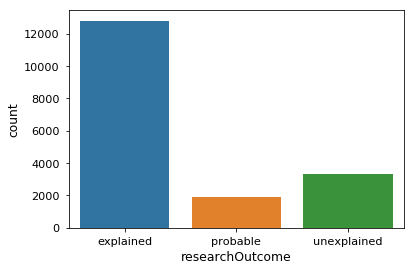

In [9]:
# Distribution for researchOutcome
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.4)

sns.countplot(x='researchOutcome',data=data)
plt.show()

by the distribution for `researchOutcome` I have decided to mutiple each `researchOutcome`='probable' by 4 (oversample) and `researchOutcome`='unexplained' by 2, we want to give these points more weight but not too much that will totally change the dataset.

## Data Preparation<a id='dp'></a>

In [10]:
oversample_data=data.copy()

# create more data points for 'probable' - add 3 copies of the dataset of point with researchOutcome='probable'
data_to_oversample=oversample_data[oversample_data['researchOutcome']=='probable']
oversample_data=pd.concat([data_to_oversample,data_to_oversample,data_to_oversample,oversample_data],ignore_index=True)
# create more data points for 'unexplained' - add 1 copies of the dataset of point with researchOutcome='unexplained'
data_to_oversample=oversample_data[oversample_data['researchOutcome']=='unexplained']
oversample_data=pd.concat([data_to_oversample,oversample_data],ignore_index=True)

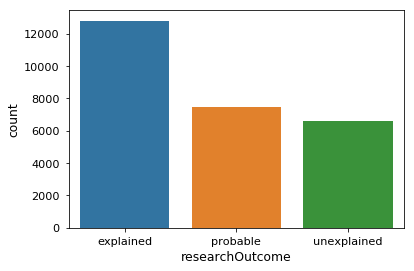

In [11]:
# Distribution for researchOutcome with the new oversampled data
sns.countplot(x='researchOutcome',data=oversample_data)
plt.show()

## Modeling<a id='model'></a>
I have decided to run 2 train jobs, one with the origin dataset on `latitude` and `longitude` features and the other with the oversample dataset on `latitude` and `longitude` features, and at the end I will compare the results.

### General Configuration for both of the Training Job in SageMaker

In [12]:
# this code was written base on "https://docs.aws.amazon.com/sagemaker/latest/dg/k-means.html#kmeans-sample-notebooks"
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker import KMeans

role = get_execution_role()
bucket='<PUT_HERE_THE_BUCKET_NAME>'
num_of_clusters = 10

### Origin Dataset - Configuration

In [13]:
output_folder_path = 'ModelingLab - 2019/original_dataset_output'
output_location = 's3://{}/{}'.format(bucket,output_folder_path)

#for 'train_instance_type' go to https://aws.amazon.com/sagemaker/pricing/instance-types/
kmeans_1 = KMeans(role=role,
                  train_instance_count=1,
                  train_instance_type='ml.p3.16xlarge',
                  output_path=output_location,
                  k=num_of_clusters)

In [14]:
# convert our DataFrame to numpy.ndarray because kmeans.record_set() Build a RecordSet from a numpy ndarray matrix
# https://sagemaker.readthedocs.io/en/stable/kmeans.html
data_numpy_1=data[['longitude','latitude']].to_numpy(dtype='float32')

In [17]:
%%time
kmeans_1.fit(kmeans_1.record_set(data_numpy_1),logs=True,job_name='ufo-modeling-lab-originalDatasetOutput')

2019-11-08 23:11:46 Starting - Starting the training job...
2019-11-08 23:11:47 Starting - Launching requested ML instances......
2019-11-08 23:13:14 Starting - Preparing the instances for training.........
2019-11-08 23:14:40 Downloading - Downloading input data
2019-11-08 23:14:40 Training - Downloading the training image....Docker entrypoint called with argument(s): train
[11/08/2019 23:15:21 INFO 140189007181632] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u


2019-11-08 23:15:37 Uploading - Uploading generated training model
2019-11-08 23:15:37 Completed - Training job completed
Training seconds: 62
Billable seconds: 62
CPU times: user 862 ms, sys: 11.5 ms, total: 873 ms
Wall time: 4min 12s


### Oversampled Dataset - Configuration

In [18]:
output_folder_path = 'ModelingLab - 2019/oversampled_dataset_output'
output_location = 's3://{}/{}'.format(bucket,output_folder_path)

#for 'train_instance_type' go to https://aws.amazon.com/sagemaker/pricing/instance-types/
kmeans_2 = KMeans(role=role,
                  train_instance_count=1,
                  train_instance_type='ml.p3.16xlarge',
                  output_path=output_location,
                  k=num_of_clusters)

In [19]:
# convert our DataFrame to numpy.ndarray because kmeans.record_set() Build a RecordSet from a numpy ndarray matrix
# https://sagemaker.readthedocs.io/en/stable/kmeans.html
data_numpy_2=oversample_data[['longitude','latitude']].to_numpy(dtype='float32')

In [20]:
%%time
kmeans_2.fit(kmeans_2.record_set(data_numpy_2),logs=True,job_name='ufo-modeling-lab-oversampledDatasetOutput')

2019-11-08 23:16:25 Starting - Starting the training job...
2019-11-08 23:16:27 Starting - Launching requested ML instances.........
2019-11-08 23:17:57 Starting - Preparing the instances for training...
2019-11-08 23:18:52 Downloading - Downloading input data...
2019-11-08 23:19:04 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[11/08/2019 23:19:35 INFO 139673144878912] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1

Training seconds: 62
Billable seconds: 62
CPU times: user 941 ms, sys: 15.7 ms, total: 956 ms
Wall time: 3min 42s


## Results<a id='results'></a>
### Downloading trained model from an S3 Bucket to Notebook instance

In [22]:
import boto3
import botocore

BUCKET_NAME = '<PUT_HERE_THE_BUCKET_NAME>'
FILE_PATH_1 = 'ModelingLab - 2019/original_dataset_output/ufo-modeling-lab-originalDatasetOutput/output/model.tar.gz'
FILE_PATH_2 = 'ModelingLab - 2019/oversampled_dataset_output/ufo-modeling-lab-oversampledDatasetOutput/output/model.tar.gz'
key_dict={'original_dataset_output':FILE_PATH_1,'oversampled_dataset_output':FILE_PATH_2}

s3 = boto3.resource('s3')

for i in key_dict:
    try:
        s3.Bucket(BUCKET_NAME).download_file(key_dict[i], i+'.tar.gz')
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            print("The object does not exist.")
        else:
            raise

### Unzip model file in the Notebook instance

In [34]:
import os

for i in key_dict:
    os.system('mkdir '+i)
    os.system('tar -C '+i+'/ -zxvf '+i+'.tar.gz')

unzip /original_dataset_output/model_algo-1
unzip /oversampled_dataset_output/model_algo-1


### Draw the points on a map
#### Install Libraries

In [35]:
!pip install mxnet
!pip install shapely
!pip install geopandas
!pip install descartes

    100% |████████████████████████████████| 25.4MB 1.8MB/s eta 0:00:01    62% |████████████████████▏           | 16.0MB 45.4MB/s eta 0:00:01
    100% |████████████████████████████████| 20.0MB 2.8MB/s eta 0:00:01   20% |██████▊                         | 4.2MB 63.5MB/s eta 0:00:01
  Found existing installation: numpy 1.14.3
    Uninstalling numpy-1.14.3:
      Successfully uninstalled numpy-1.14.3
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


#### original dataset output

In [39]:
import mxnet as mx

Kmeans_model_params_1 = mx.ndarray.load(list(key_dict.keys())[0]+'/model_algo-1')
cluster_centroids_kmeans_1 = pd.DataFrame(Kmeans_model_params_1[0].asnumpy())
cluster_centroids_kmeans_1.columns=['longitude','latitude']
cluster_centroids_kmeans_1

,longitude,latitude
0,-87.168442,41.502136
1,3.913269,50.439400
2,-118.426498,35.273296
3,147.612915,-31.971569
4,-82.494690,31.490051
5,97.864342,15.963917
6,-74.870834,41.306282
7,-122.310440,48.011696
8,-98.078049,35.381287
9,-6.308319,-25.694458


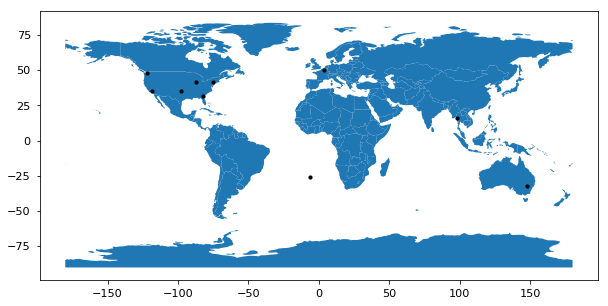

In [48]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(cluster_centroids_kmeans_1['longitude'], cluster_centroids_kmeans_1['latitude'])]
gdf = GeoDataFrame(cluster_centroids_kmeans_1, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='black', markersize=15);
plt.show()

#### oversampled dataset output

In [40]:
import mxnet as mx

Kmeans_model_params_2 = mx.ndarray.load(list(key_dict.keys())[1]+'/model_algo-1')
cluster_centroids_kmeans_2 = pd.DataFrame(Kmeans_model_params_2[0].asnumpy())
cluster_centroids_kmeans_2.columns=['longitude','latitude']
cluster_centroids_kmeans_2

,longitude,latitude
0,-99.213089,34.573288
1,3.382004,50.712002
2,120.959106,-5.910084
3,-117.671219,35.702499
4,-75.094498,41.331425
5,18.683708,-25.356354
6,-121.119476,47.015095
7,-153.243866,44.520145
8,-88.412445,41.321365
9,-82.486305,31.290245


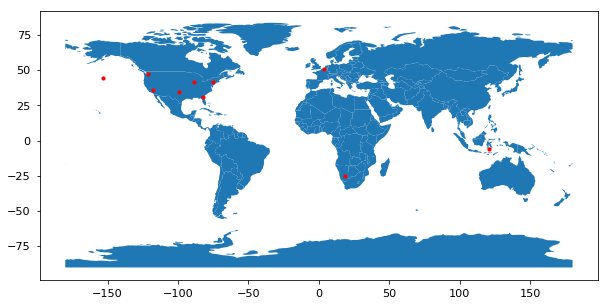

In [50]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(cluster_centroids_kmeans_2['longitude'], cluster_centroids_kmeans_2['latitude'])]
gdf = GeoDataFrame(cluster_centroids_kmeans_2, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);
plt.show()

## Summary <a id='summary'></a>
for summary, from the points on the maps we can see that:
1. six points that were placed in USA are identical for both of the trained models.
1. the point that was placed in Europe is identical for both of the trained models.
1. rest of the points were placed on different places for both of the trained models.

I can't say if one model is better than the other, but it was a fun ride!